In [7]:
import numpy as np
from numpy import random
import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
gen_req1 = np.load('/content/drive/My Drive/gen_req.npy')
req1 = np.load('/content/drive/My Drive/req.npy')

In [9]:
#req1 = req1[20000:2005000]
#gen_req1 = gen_req1[20000:2005000]
req1.shape,gen_req1.shape

((2005000,), (2255000,))

In [10]:
N = 100 # total ids 
pi = 3.14

LRU

In [11]:
def LRU(y, x, request_time,con):
  [N,I] = x.shape
  J = len(y)
  old = y.reshape(J*N).copy()
  for j in range(J):
    x_t_j = np.zeros(N)
    file_req_time = np.zeros(N)

    # to find which users are connected to this cache 
    connected_users = []
    for k in range(I):
      if con[k,j] == 1:
        connected_users.append(k)
    for k in range(len(connected_users)):
      x_t_j += x[:,connected_users[k]]
      file_req_time = np.maximum(file_req_time, request_time[:,connected_users[k]])
    x_t_j = np.minimum(np.ones(N),x_t_j)

    a1 = np.transpose(np.logical_and(y[j],np.logical_not(np.logical_and(y[j],np.transpose(x_t_j)))))# file which is not requested but still in the cache
    b1 = np.transpose(np.logical_and(np.transpose(x_t_j),np.logical_not(np.logical_and(y[j],np.transpose(x_t_j))))) # file requested but not in the cache.
    a = np.sum(a1)
    b = np.sum(b1)

    if a>0 and b>0:
      if a>b:
        ind = []
        for k in range(N):
          if a1[k] == 1:
            ind.append(k)
        t = np.zeros(a)
        for k in range(a):
          t[k] = file_req_time[ind[k]]
        replace = (t).argsort()[:b]
        for k in range(b):
          y[j,ind[int(replace[k])]] = 0
        for k in range(N):
          if b1[k] == 1:
            y[j,k] = 1
      
      else:
        for k in range(N):
          if a1[k] == 1:
            y[j,k] = 0
        
        ind = []
        for k in range(N):
          if b1[k] == 1:
            ind.append(k)
        t = np.zeros(b)
        for k in range(b):
          t[k] = file_req_time[ind[k]]
        replace = (t).argsort()[:a]
        for k in range(a):
          y[j,ind[int(replace[k])]] = 1
  new = y.reshape(J*N).copy()
  download = np.sum(np.logical_and(new,np.logical_not(old)))
  return y,download

LFU

In [12]:
def LFU(y,x,freq,con):
  [N,I] = x.shape
  J = len(y)
  old = y.reshape(J*N).copy()
  for j in range(J):
    file_freq = np.zeros(N)
    x_t_j = np.zeros(N)

    # to find which users are connected to this cache 
    connected_users = []
    for k in range(I):
      if con[k,j] == 1:
        connected_users.append(k)
    for k in range(len(connected_users)):
      x_t_j += x[:,connected_users[k]]
      file_freq += freq[:,connected_users[k]]
    x_t_j = np.minimum(np.ones(N),x_t_j)

    a1 = np.transpose(np.logical_and(y[j],np.logical_not(np.logical_and(y[j],np.transpose(x_t_j)))))# file which is not requested but still in the cache
    b1 = np.transpose(np.logical_and(np.transpose(x_t_j),np.logical_not(np.logical_and(y[j],np.transpose(x_t_j))))) # file requested but not in the cache.
    a = np.sum(a1)
    b = np.sum(b1)
  
    if a>0 and b>0:
      if a>b:
        ind = []
        for k in range(N):
          if a1[k] == 1:
            ind.append(k)
        t = np.zeros(a)
        for k in range(a):
          t[k] = file_freq[ind[k]]
        replace = (t).argsort()[:b]
        for k in range(b):
          y[j,ind[int(replace[k])]] = 0
        for k in range(N):
          if b1[k] == 1:
            y[j,k] = 1
      else:
        for k in range(N):
          if a1[k] == 1:
            y[j,k] = 0
        ind = []
        for k in range(N):
          if b1[k] == 1:
            ind.append(k)
        t = np.zeros(b)
        for k in range(b):
          t[k] = file_freq[ind[k]]
        replace = (t).argsort()[:a]
        for k in range(a):
          y[j,ind[int(replace[k])]] = 1

  new = y.reshape(J*N).copy()
  download = np.sum(np.logical_and(new,np.logical_not(old)))
  return y,download

perturbed count

In [13]:
def per_count(eta,count):
  [N,I] = count.shape
  p_count = np.zeros((N,I),dtype = float)
  for i in range(I):
    p_count[:,i] = count[:,i] + (eta*random.normal(0,1,[N,1])).reshape(N)
  return p_count

GREEDY

In [14]:
def Greedy(con,count):
  [I,J] = con.shape
  [N,I] = count.shape
  load = np.zeros((1,J),dtype = float)

  for i in range(I):
    for f in range(N):
      if count[f,i] < 0:
        count[f,i] = 0
  
  loadc = 0
  y = np.zeros((J,N),dtype = float)
  z = np.zeros((I,N),dtype = float)
  mark = np.zeros((I,N),dtype = float)

  while(loadc < J):
    best_cache = -1
    best_file = -1
    best_imp = -1

    for j in range(J):
      if load[0,j] < C:
        for f in range(N):
          if y[j,f] != 1:
            imp = 0

            for i in range(I):
              if con[i,j] == 1 and mark[i,f] == 0:
                imp += count[f,i]

            if imp >= best_imp:
              best_cache = j
              best_file = f
              best_imp = imp

    y[best_cache,best_file] = 1

    for i in range(I):
      if con[i,best_cache] == 1:
        mark[i,best_cache] = 1

    load[0,best_cache] += 1
    if load[0,best_cache] == C:
      loadc += 1
  
  for i in range(I):
    for f in range(N):
      for j in range(J):
        if con[i,j] == 1:
          z[i,f] = np.maximum(y[j,f],z[i,f])
      
  return y,z

SINGLE CACHE

In [15]:
I = 1 #users
T = 100000
degree = 1
J = 1 #caches
C = 5
connection = np.array([[1]])
connection.shape

(1, 1)

In [16]:
req = req1[:I*T].reshape(I,T)
req

array([[17, 80, 26, ..., 69, 34, 83]])

In [17]:
gen_req = gen_req1[:I*T].reshape(I,T)
gen_req

array([[17, 80, 26, ..., 64, 79, 87]])

In [18]:
y_LRU = np.zeros((J,N),dtype = float)
y_LFU = np.zeros((J,N),dtype = float)
y_FTPL = np.zeros((J,N),dtype = float)
y_LSTM = np.zeros((J,N),dtype = float)
y_LSTM[:,:C] = np.ones((J,C),dtype = float)
y_FTPL[:,:C] = np.ones((J,C),dtype = float)
y_LRU[:,:C] = np.ones((J,C),dtype = float)
y_LFU[:,:C] = np.ones((J,C),dtype = float)
count = np.zeros((N,I),dtype = float)
reward_LSTM =  np.zeros(T)
reward_FTPL =  np.zeros(T)
reward_LRU =  np.zeros(T)
reward_LFU =  np.zeros(T)
hits_FTPL =  []
hits_LRU =  []
hits_LFU =  []
hits_LSTM = []
download_FTPL =  []
download_LRU =  []
download_LFU =  []
download_LSTM = []
FTPL_downloads_slotwise = np.zeros(T)
LFU_downloads_slotwise = np.zeros(T)
LRU_downloads_slotwise = np.zeros(T)
LSTM_downloads_slotwise = np.zeros(T)
req_time = np.zeros((N,I),dtype = float) 
req_time1 = np.zeros((N,I),dtype = float) 

for t in range(T):
  x_t1 = np.zeros((N,I),dtype = int)
  x_t = np.zeros((N,I),dtype = int)
  for i in range(I):
    x_t[req[i,t],i] += 1
    x_t1[gen_req[i,t],i] += 1
    count[int(req[i,t]),i] += 1
    req_time[int(req[i,t]),i] = t+1
    req_time1[int(gen_req[i,t]),i] = t+1
  
  ireward_LRU =  np.zeros(I)
  ireward_LSTM =  np.zeros(I)
  ireward_LFU =  np.zeros(I)
  ireward_FTPL =  np.zeros(I)
  
  for i in range(I):
    temp1 = np.zeros(N)
    temp2 = np.zeros(N)
    temp3 = np.zeros(N)
    temp4 = np.zeros(N)
    connected_cache = []
    for j in range(J):
      if connection[i,j] == 1:
        connected_cache.append(j)
    for k in range(len(connected_cache)):
      temp1 += y_FTPL[connected_cache[k],:]
      temp2 += y_LFU[connected_cache[k],:]
      temp3 += y_LRU[connected_cache[k],:]
      temp4 += y_LSTM[connected_cache[k],:]
    ireward_FTPL[i] += np.dot(np.minimum(np.ones(N),temp1),x_t[:,i])
    ireward_LFU[i] += np.dot(np.minimum(np.ones(N),temp2),x_t[:,i])
    ireward_LRU[i] += np.dot(np.minimum(np.ones(N),temp3),x_t[:,i])
    ireward_LSTM[i] += np.dot(np.minimum(np.ones(N),temp4),x_t1[:,i])

  reward_FTPL[t] =  np.sum(ireward_FTPL)
  reward_LRU[t] =  np.sum(ireward_LRU)
  reward_LFU[t] =  np.sum(ireward_LFU)
  reward_LSTM[t] =  np.sum(ireward_LSTM)
  reward_LSTMc = np.sum(reward_LSTM)
  reward_FTPLc = np.sum(reward_FTPL)
  reward_LRUc = np.sum(reward_LRU)
  reward_LFUc = np.sum(reward_LFU)

  [y_LFU,LFU_downloads_slotwise[t]] = LFU(y_LFU,x_t,count,connection)
  [y_LRU,LRU_downloads_slotwise[t]] = LRU(y_LRU,x_t,req_time,connection)
  [y_LSTM,LSTM_downloads_slotwise[t]] = LRU(y_LSTM,x_t1,req_time1,connection)

  eta = pow(4*pi*np.log(N),-.25)*pow((t+1)/C,.5)
  perturbed_count=per_count(eta,count)
  old_FTPL = y_FTPL.reshape(J*N)
  add = (-perturbed_count[:,0]).argsort()[:C]
  y_FTPL = np.zeros((J,N),dtype = float)
  for k in range(len(add)):
    y_FTPL[0,int(add[k])] = 1 
  new_FTPL = y_FTPL.reshape(J*N)
  FTPL_downloads_slotwise[t] = (np.sum(np.logical_and(new_FTPL,np.logical_not(old_FTPL))))
 
  download_FTPL.append(np.sum(FTPL_downloads_slotwise))
  download_LFU.append(np.sum(LFU_downloads_slotwise))
  download_LRU.append(np.sum(LRU_downloads_slotwise))
  download_LSTM.append(np.sum(LSTM_downloads_slotwise))

  hits_LRU.append(reward_LRUc)
  hits_LFU.append(reward_LFUc)
  hits_FTPL.append(reward_FTPLc)
  hits_LSTM.append(reward_LSTMc)

  if t %10000 == 0:
    print(t,download_FTPL[t],download_LFU[t],download_LRU[t],download_LSTM[t])

0 5.0 1.0 1.0 1.0
10000 36633.0 9397.0 9477.0 9477.0
20000 63022.0 18715.0 18994.0 18994.0
30000 85113.0 28029.0 28465.0 27616.0
40000 102251.0 37355.0 37919.0 36214.0
50000 117242.0 46740.0 47407.0 44815.0
60000 130221.0 56073.0 56865.0 53412.0
70000 141455.0 65392.0 66324.0 62018.0
80000 152140.0 74733.0 75808.0 70578.0
90000 161937.0 84087.0 85340.0 79217.0


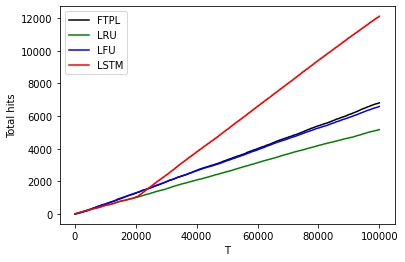

In [19]:
plt.plot(hits_FTPL,'black',label='FTPL')
plt.plot(hits_LRU,'green',label='LRU')
plt.plot(hits_LFU,'blue',label='LFU')
plt.plot(hits_LSTM,'red',label='LSTM')
plt.xlabel('T')
plt.ylabel('Total hits')
plt.legend()
plt.savefig('Total hits(I=J=1).png')

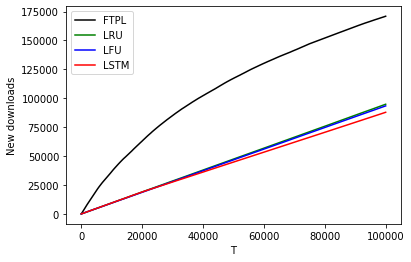

In [20]:
plt.plot(download_FTPL,'black',label='FTPL')
plt.plot(download_LRU,'green',label='LRU')
plt.plot(download_LFU,'blue',label='LFU')
plt.plot(download_LSTM,'red',label='LSTM')
plt.xlabel('T')
plt.ylabel('New downloads')
plt.legend()
plt.savefig('New downloads(I=J=1).png')

I = 5 J = 3 d = 3

In [37]:
C = 5
I = 5
J = 3
degree = 3
T = 30000

In [38]:
connection = np.zeros((I,J),dtype = int)
i = 0
for j in range(J):
  x = 0
  while x < degree:
    connection[i,j] = 1
    x += 1
    i += 1
    if i == I:
      i = 0
connection

array([[1, 1, 0],
       [1, 0, 1],
       [1, 0, 1],
       [0, 1, 1],
       [0, 1, 0]])

In [39]:
gen_req1 = np.load('/content/drive/My Drive/gen_req.npy')
req1 = np.load('/content/drive/My Drive/req.npy')
req1 = req1[20000:]
gen_req1 = gen_req1[20000:]

In [40]:
req = req1.reshape(I,-1)
req.shape

(5, 397000)

In [41]:
gen_req = gen_req1.reshape(I,-1)
gen_req.shape

(5, 447000)

In [42]:
y_LRU = np.zeros((J,N),dtype = float)
y_LFU = np.zeros((J,N),dtype = float)
y_FTPL = np.zeros((J,N),dtype = float)
y_LSTM = np.zeros((J,N),dtype = float)
y_LSTM[:,:C] = np.ones((J,C),dtype = float)
y_FTPL[:,:C] = np.ones((J,C),dtype = float)
y_LRU[:,:C] = np.ones((J,C),dtype = float)
y_LFU[:,:C] = np.ones((J,C),dtype = float)
count = np.zeros((N,I),dtype = float)
reward_LSTM =  np.zeros(T)
reward_FTPL =  np.zeros(T)
reward_LRU =  np.zeros(T)
reward_LFU =  np.zeros(T)
hits_FTPL =  []
hits_LRU =  []
hits_LFU =  []
hits_LSTM = []
download_FTPL =  []
download_LRU =  []
download_LFU =  []
download_LSTM = []
FTPL_downloads_slotwise = np.zeros(T)
LFU_downloads_slotwise = np.zeros(T)
LRU_downloads_slotwise = np.zeros(T)
LSTM_downloads_slotwise = np.zeros(T)
req_time = np.zeros((N,I),dtype = float) 
req_time1 = np.zeros((N,I),dtype = float) 

for t in range(T):
  x_t1 = np.zeros((N,I),dtype = int)
  x_t = np.zeros((N,I),dtype = int)
  for i in range(I):
    x_t[req[i,t],i] += 1
    x_t1[gen_req[i,t],i] += 1
    count[int(req[i,t]),i] += 1
    req_time[int(req[i,t]),i] = t+1
    req_time1[int(gen_req[i,t]),i] = t+1
  
  ireward_LRU =  np.zeros(I)
  ireward_LSTM =  np.zeros(I)
  ireward_LFU =  np.zeros(I)
  ireward_FTPL =  np.zeros(I)
  
  for i in range(I):
    temp1 = np.zeros(N)
    temp2 = np.zeros(N)
    temp3 = np.zeros(N)
    temp4 = np.zeros(N)
    connected_cache = []
    for j in range(J):
      if connection[i,j] == 1:
        connected_cache.append(j)
    for k in range(len(connected_cache)):
      temp1 += y_FTPL[connected_cache[k],:]
      temp2 += y_LFU[connected_cache[k],:]
      temp3 += y_LRU[connected_cache[k],:]
      temp4 += y_LSTM[connected_cache[k],:]
    ireward_FTPL[i] += np.dot(np.minimum(np.ones(N),temp1),x_t[:,i])
    ireward_LFU[i] += np.dot(np.minimum(np.ones(N),temp2),x_t[:,i])
    ireward_LRU[i] += np.dot(np.minimum(np.ones(N),temp3),x_t[:,i])
    ireward_LSTM[i] += np.dot(np.minimum(np.ones(N),temp4),x_t1[:,i])

  reward_FTPL[t] =  np.sum(ireward_FTPL)
  reward_LRU[t] =  np.sum(ireward_LRU)
  reward_LFU[t] =  np.sum(ireward_LFU)
  reward_LSTM[t] =  np.sum(ireward_LSTM)
  reward_LSTMc = np.sum(reward_LSTM)
  reward_FTPLc = np.sum(reward_FTPL)
  reward_LRUc = np.sum(reward_LRU)
  reward_LFUc = np.sum(reward_LFU)

  [y_LFU,LFU_downloads_slotwise[t]] = LFU(y_LFU,x_t,count,connection)
  [y_LRU,LRU_downloads_slotwise[t]] = LRU(y_LRU,x_t,req_time,connection)
  [y_LSTM,LSTM_downloads_slotwise[t]] = LRU(y_LSTM,x_t1,req_time1,connection)

  eta = I*pow(4*pi*np.log(N*I),-.25)*pow((t+1)/(J*degree*C),.5)
  perturbed_count=per_count(eta,count)
  old_FTPL = y_FTPL.reshape(J*N).copy()
  [y_FTPL,z] = Greedy(connection,perturbed_count)
  new_FTPL = y_FTPL.reshape(J*N).copy()
  FTPL_downloads_slotwise[t] = (np.sum(np.logical_and(new_FTPL,np.logical_not(old_FTPL))))
 
  download_FTPL.append(np.sum(FTPL_downloads_slotwise))
  download_LFU.append(np.sum(LFU_downloads_slotwise))
  download_LRU.append(np.sum(LRU_downloads_slotwise))
  download_LSTM.append(np.sum(LSTM_downloads_slotwise))

  hits_LRU.append(reward_LRUc)
  hits_LFU.append(reward_LFUc)
  hits_FTPL.append(reward_FTPLc)
  hits_LSTM.append(reward_LSTMc)

  if t %1000 == 0:
    print(t,download_FTPL[t],download_LFU[t],download_LRU[t],download_LSTM[t],hits_FTPL[t],hits_LFU[t],hits_LRU[t],hits_LSTM[t])

0 14.0 9.0 9.0 8.0 0.0 0.0 0.0 0.0
1000 13396.0 8437.0 8469.0 7895.0 431.0 374.0 362.0 634.0
2000 26211.0 16792.0 16909.0 15702.0 848.0 802.0 735.0 1302.0
3000 38457.0 25204.0 25332.0 23453.0 1292.0 1160.0 1118.0 2014.0
4000 50353.0 33591.0 33809.0 31031.0 1713.0 1538.0 1458.0 2760.0
5000 61845.0 41969.0 42253.0 38715.0 2174.0 1925.0 1820.0 3436.0
6000 72829.0 50354.0 50743.0 46447.0 2601.0 2311.0 2154.0 4172.0
7000 82940.0 58705.0 59182.0 54194.0 3078.0 2708.0 2512.0 4877.0
8000 92543.0 67061.0 67586.0 61930.0 3550.0 3122.0 2900.0 5592.0
9000 101602.0 75447.0 76026.0 69427.0 3983.0 3532.0 3265.0 6406.0
10000 109975.0 83765.0 84413.0 77284.0 4424.0 3991.0 3649.0 7037.0
11000 117734.0 92089.0 92861.0 85040.0 4869.0 4432.0 4015.0 7724.0
12000 125137.0 100503.0 101317.0 92785.0 5291.0 4820.0 4360.0 8412.0
13000 132478.0 108823.0 109734.0 100266.0 5709.0 5222.0 4752.0 9218.0
14000 139465.0 117218.0 118201.0 108003.0 6133.0 5578.0 5101.0 9919.0
15000 146505.0 125610.0 126670.0 115746.0 6540

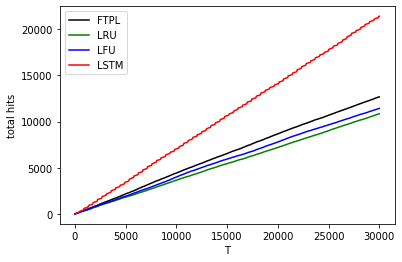

In [43]:
plt.plot(hits_FTPL,'black',label='FTPL')
plt.plot(hits_LRU,'green',label='LRU')
plt.plot(hits_LFU,'blue',label='LFU')
plt.plot(hits_LSTM,'red',label='LSTM')
plt.xlabel('T')
plt.ylabel('total hits')
plt.legend()
plt.savefig('Total hits(I=5 J=3 d=3).png')

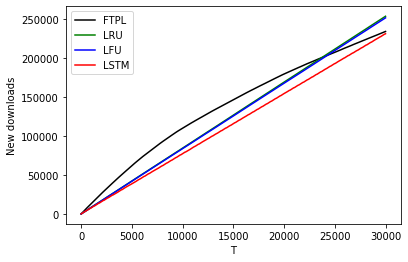

In [45]:
plt.plot(download_FTPL,'black',label='FTPL')
plt.plot(download_LRU,'green',label='LRU')
plt.plot(download_LFU,'blue',label='LFU')
plt.plot(download_LSTM,'red',label='LSTM')
plt.xlabel('T')
plt.ylabel('New downloads')
plt.legend()
plt.savefig('New downloads(I=5 J=3 d=3).png')

I = 15 J = 10 d = 7

In [53]:
I = 15
J = 10
C = 15
degree = 7
T = 10000

In [54]:
connection = np.zeros((I,J),dtype = int)
i = 0
for j in range(J):
  x = 0
  while x < degree:
    connection[i,j] = 1
    x += 1
    i += 1
    if i == I:
      i = 0
connection

array([[1, 0, 1, 0, 1, 0, 1, 0, 1, 0],
       [1, 0, 1, 0, 1, 0, 1, 0, 1, 0],
       [1, 0, 1, 0, 1, 0, 1, 0, 1, 0],
       [1, 0, 1, 0, 1, 0, 1, 0, 0, 1],
       [1, 0, 1, 0, 1, 0, 0, 1, 0, 1],
       [1, 0, 1, 0, 0, 1, 0, 1, 0, 1],
       [1, 0, 0, 1, 0, 1, 0, 1, 0, 1],
       [0, 1, 0, 1, 0, 1, 0, 1, 0, 1],
       [0, 1, 0, 1, 0, 1, 0, 1, 0, 1],
       [0, 1, 0, 1, 0, 1, 0, 1, 0, 1],
       [0, 1, 0, 1, 0, 1, 0, 1, 0, 0],
       [0, 1, 0, 1, 0, 1, 0, 0, 1, 0],
       [0, 1, 0, 1, 0, 0, 1, 0, 1, 0],
       [0, 1, 0, 0, 1, 0, 1, 0, 1, 0],
       [0, 0, 1, 0, 1, 0, 1, 0, 1, 0]])

In [55]:
gen_req1 = np.load('/content/drive/My Drive/gen_req.npy')
req1 = np.load('/content/drive/My Drive/req.npy')
req1 = req1[20000:2004995]
gen_req1 = gen_req1[20000:]

In [56]:
req = req1.reshape(I,-1)
req.shape

(15, 132333)

In [57]:
gen_req = gen_req1.reshape(I,-1)
gen_req.shape

(15, 149000)

In [58]:
y_LRU = np.zeros((J,N),dtype = float)
y_LFU = np.zeros((J,N),dtype = float)
y_FTPL = np.zeros((J,N),dtype = float)
y_LSTM = np.zeros((J,N),dtype = float)
y_LSTM[:,:C] = np.ones((J,C),dtype = float)
y_FTPL[:,:C] = np.ones((J,C),dtype = float)
y_LRU[:,:C] = np.ones((J,C),dtype = float)
y_LFU[:,:C] = np.ones((J,C),dtype = float)
count = np.zeros((N,I),dtype = float)
reward_LSTM =  np.zeros(T)
reward_FTPL =  np.zeros(T)
reward_LRU =  np.zeros(T)
reward_LFU =  np.zeros(T)
hits_FTPL =  []
hits_LRU =  []
hits_LFU =  []
hits_LSTM = []
download_FTPL =  []
download_LRU =  []
download_LFU =  []
download_LSTM = []
FTPL_downloads_slotwise = np.zeros(T)
LFU_downloads_slotwise = np.zeros(T)
LRU_downloads_slotwise = np.zeros(T)
LSTM_downloads_slotwise = np.zeros(T)
req_time = np.zeros((N,I),dtype = float) 
req_time1 = np.zeros((N,I),dtype = float) 

for t in range(T):
  x_t1 = np.zeros((N,I),dtype = int)
  x_t = np.zeros((N,I),dtype = int)
  for i in range(I):
    x_t[req[i,t],i] += 1
    x_t1[gen_req[i,t],i] += 1
    count[int(req[i,t]),i] += 1
    req_time[int(req[i,t]),i] = t+1
    req_time1[int(gen_req[i,t]),i] = t+1
  
  ireward_LRU =  np.zeros(I)
  ireward_LSTM =  np.zeros(I)
  ireward_LFU =  np.zeros(I)
  ireward_FTPL =  np.zeros(I)
  
  for i in range(I):
    temp1 = np.zeros(N)
    temp2 = np.zeros(N)
    temp3 = np.zeros(N)
    temp4 = np.zeros(N)
    connected_cache = []
    for j in range(J):
      if connection[i,j] == 1:
        connected_cache.append(j)
    for k in range(len(connected_cache)):
      temp1 += y_FTPL[connected_cache[k],:]
      temp2 += y_LFU[connected_cache[k],:]
      temp3 += y_LRU[connected_cache[k],:]
      temp4 += y_LSTM[connected_cache[k],:]
    ireward_FTPL[i] += np.dot(np.minimum(np.ones(N),temp1),x_t[:,i])
    ireward_LFU[i] += np.dot(np.minimum(np.ones(N),temp2),x_t[:,i])
    ireward_LRU[i] += np.dot(np.minimum(np.ones(N),temp3),x_t[:,i])
    ireward_LSTM[i] += np.dot(np.minimum(np.ones(N),temp4),x_t1[:,i])

  reward_FTPL[t] =  np.sum(ireward_FTPL)
  reward_LRU[t] =  np.sum(ireward_LRU)
  reward_LFU[t] =  np.sum(ireward_LFU)
  reward_LSTM[t] =  np.sum(ireward_LSTM)
  reward_LSTMc = np.sum(reward_LSTM)
  reward_FTPLc = np.sum(reward_FTPL)
  reward_LRUc = np.sum(reward_LRU)
  reward_LFUc = np.sum(reward_LFU)

  [y_LFU,LFU_downloads_slotwise[t]] = LFU(y_LFU,x_t,count,connection)
  [y_LRU,LRU_downloads_slotwise[t]] = LRU(y_LRU,x_t,req_time,connection)
  [y_LSTM,LSTM_downloads_slotwise[t]] = LRU(y_LSTM,x_t1,req_time1,connection)

  eta = I*pow(4*pi*np.log(N*I),-.25)*pow((t+1)/(J*degree*C),.5)
  perturbed_count=per_count(eta,count)
  old_FTPL = y_FTPL.reshape(J*N).copy()
  [y_FTPL,z] = Greedy(connection,perturbed_count)
  new_FTPL = y_FTPL.reshape(J*N).copy()
  FTPL_downloads_slotwise[t] = (np.sum(np.logical_and(new_FTPL,np.logical_not(old_FTPL))))
 
  download_FTPL.append(np.sum(FTPL_downloads_slotwise))
  download_LFU.append(np.sum(LFU_downloads_slotwise))
  download_LRU.append(np.sum(LRU_downloads_slotwise))
  download_LSTM.append(np.sum(LSTM_downloads_slotwise))

  hits_LRU.append(reward_LRUc)
  hits_LFU.append(reward_LFUc)
  hits_FTPL.append(reward_FTPLc)
  hits_LSTM.append(reward_LSTMc)

  if t %100 == 0:
    print(t,download_FTPL[t],download_LFU[t],download_LRU[t],download_LSTM[t],hits_FTPL[t],hits_LFU[t],hits_LRU[t],hits_LSTM[t])

0 141.0 69.0 69.0 60.0 0.0 0.0 0.0 1.0
100 9911.0 5826.0 5875.0 5775.0 482.0 439.0 371.0 392.0
200 19891.0 11520.0 11678.0 11063.0 990.0 902.0 738.0 795.0
300 29736.0 17185.0 17464.0 16411.0 1459.0 1346.0 1087.0 1199.0
400 39415.0 22856.0 23264.0 22045.0 1935.0 1806.0 1454.0 1611.0
500 48916.0 28489.0 28917.0 27541.0 2412.0 2234.0 1863.0 2005.0
600 57992.0 34110.0 34661.0 32707.0 2884.0 2632.0 2225.0 2434.0
700 66993.0 39707.0 40424.0 38457.0 3385.0 3051.0 2598.0 2797.0
800 75772.0 45342.0 46170.0 43755.0 3858.0 3454.0 2977.0 3212.0
900 84362.0 51007.0 51973.0 48891.0 4334.0 3834.0 3355.0 3689.0
1000 92804.0 56658.0 57762.0 54507.0 4822.0 4202.0 3720.0 4090.0
1100 100916.0 62282.0 63552.0 59800.0 5308.0 4600.0 4088.0 4509.0
1200 108969.0 67788.0 69235.0 65126.0 5794.0 5029.0 4494.0 4906.0
1300 116663.0 73529.0 75026.0 70831.0 6265.0 5398.0 4861.0 5303.0
1400 124108.0 79164.0 80688.0 76202.0 6715.0 5784.0 5256.0 5702.0
1500 131445.0 84693.0 86327.0 81393.0 7190.0 6199.0 5663.0 6149.0
16

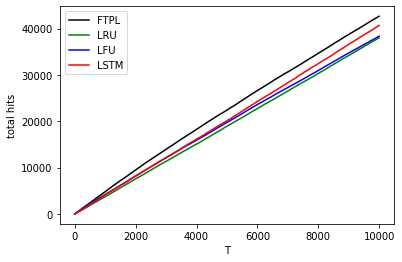

In [59]:
plt.plot(hits_FTPL,'black',label='FTPL')
plt.plot(hits_LRU,'green',label='LRU')
plt.plot(hits_LFU,'blue',label='LFU')
plt.plot(hits_LSTM,'red',label='LSTM')
plt.xlabel('T')
plt.ylabel('total hits')
plt.legend()
plt.savefig('Total hits(I=15 J=10 d=7).png')

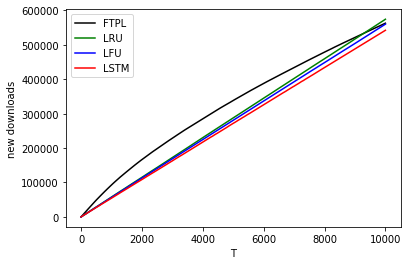

In [60]:
plt.plot(download_FTPL,'black',label='FTPL')
plt.plot(download_LRU,'green',label='LRU')
plt.plot(download_LFU,'blue',label='LFU')
plt.plot(download_LSTM,'red',label='LSTM')
plt.xlabel('T')
plt.ylabel('new downloads')
plt.legend()
plt.savefig('New downloads(I=15 J=10 d=7).png')